# Single Microburst Artifitial Neural Network (ANN)
To identify single microbursts in the SAMPEX 20 ms data. The training data comes from the microbursts identified with the O'Brien et al.'s, 2003 burst parameter.

In [1]:
import pathlib

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import progressbar2

import microburst_ann.config as config

Specify train and test data paths

In [2]:
train_path = pathlib.Path(config.PROJECT_DIR, 'data', 'train.csv')
test_path = pathlib.Path(config.PROJECT_DIR, 'data', 'test.csv')

## Load data

In [3]:
# Load the csv files
train_df = pd.read_csv(train_path, index_col=0)
test_df = pd.read_csv(test_path, index_col=0)
# Drop the NaN rows
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
# Pop off the training and test labels and make them into their own pd.DataFrames
train_labels = train_df.pop('label')
test_labels = test_df.pop('label')

## Visualize the microburst and nonmicrobursts

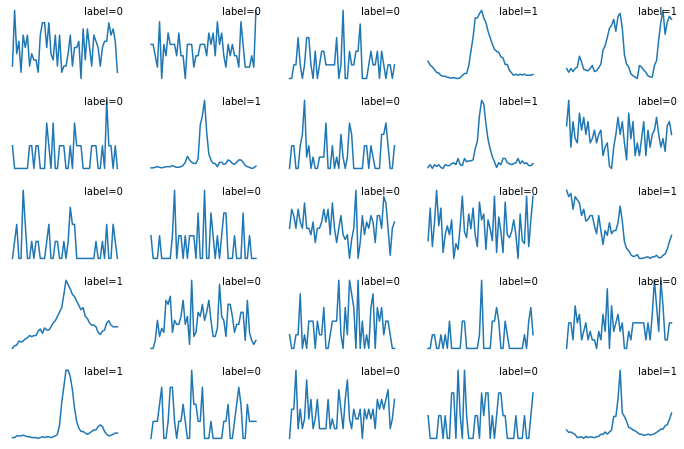

In [4]:
plot_n = (5,5)
rand_idx = np.random.randint(0, train_df.shape[0], size=plot_n)
fig, ax = plt.subplots(nrows=plot_n[0], ncols=plot_n[1], figsize=(12,8))

for i, ax_row in enumerate(ax):
    for j, ax_i in enumerate(ax_row):
        ax_i.plot(train_df.iloc[rand_idx[i,j]])
        ax_i.text(1, 1, f'label={train_labels.iloc[rand_idx[i,j]]}', 
                    va='top', ha='right', transform=ax_i.transAxes)
        ax_i.axis('off')

## pd.DataFrame -> tf.Dataset
This streamlines the data input into Tensorflow and Karas. Now sure what else this is good for.

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df.to_numpy(), train_labels.to_numpy())
    )
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df.to_numpy(), test_labels.to_numpy())
    )
shuffled_train_dataset = train_dataset.shuffle(train_df.shape[0]).batch(1)

In [6]:
def create_ann_model():
    """ 
    Specify the ANN model architecture and compile it.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(50,)),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [7]:
model = create_ann_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,546
Trainable params: 1,546
Non-trainable params: 0
_________________________________________________________________


So we have 1546 parameters to train. And now lets set up the checkpoint directory to save the model parameters to a binary (h5) file.

In [8]:
checkpoint_path = config.PROJECT_DIR / 'ann' / 'model' / 'model.cp'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
    )

In [9]:
history = model.fit(shuffled_train_dataset, # Normally, you would indicate the data and labels. However, the tf.Dataset takes care of the input.
                    validation_data=(test_df.to_numpy(), test_labels), # Test dataset used to calculate the model accuracy.
                    epochs=3, # How many epochs to use (train using the entire train dataset epoch times.)
                    callbacks=[checkpoint_callback]) # Set up the callback to save the model.

Epoch 1/3
112627/112628 [============================>.] - ETA: 0s - loss: 0.5081 - accuracy: 0.9881
Epoch 00001: saving model to /Users/mshumko/Documents/research/sampex/microburst_ann/microburst_ann/ann/model/model.cp
112628/112628 [==============================] - 172s 2ms/step - loss: 0.5081 - accuracy: 0.9881 - val_loss: 0.5056 - val_accuracy: 0.9930
Epoch 2/3
112614/112628 [============================>.] - ETA: 0s - loss: 0.5043 - accuracy: 0.9949
Epoch 00002: saving model to /Users/mshumko/Documents/research/sampex/microburst_ann/microburst_ann/ann/model/model.cp
112628/112628 [==============================] - 172s 2ms/step - loss: 0.5043 - accuracy: 0.9949 - val_loss: 0.5046 - val_accuracy: 0.9948
Epoch 3/3
112616/112628 [============================>.] - ETA: 0s - loss: 0.5042 - accuracy: 0.9951
Epoch 00003: saving model to /Users/mshumko/Documents/research/sampex/microburst_ann/microburst_ann/ann/model/model.cp
112628/112628 [==============================] - 178s 2ms/step

Now to practice the checkpoint API, lets load the trained weights into a new model and set its weights

In [10]:
model2 = create_ann_model()
model2.load_weights(checkpoint_path)

## Evaluate the model

The model.evaluate line below is the same as this handwritten loop:

In [11]:
# n_correct=0
# for i in range(test_df.shape[0]):
#     if round(model(test_df.iloc[i].to_numpy().reshape((1, 50))).numpy()[0][0]) == test_labels.iloc[i]:
#         n_correct += 1
# print(f'n_correct={n_correct}, n_correct/n_total={n_correct/test_df.shape[0]}')

In [12]:
model.evaluate(test_df.to_numpy(), test_labels, verbose=2)

880/880 - 1s - loss: 0.5047 - accuracy: 0.9950


[0.5047160387039185, 0.9949559569358826]

*** model.evaluate is optimized so it is MUCH quicker. ***

We got a 99.5% accuracy. Nice!

## Model accuracy and loss functions 
plots as a function of Epoch

(0.0, 1.0)

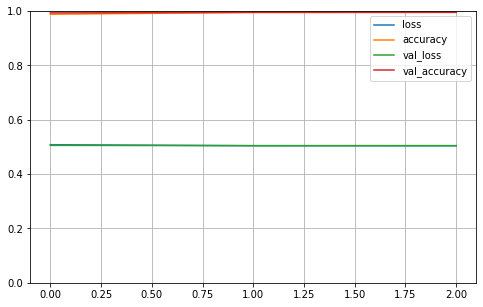

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylim(0, 1) # set the vertical range to [0-1]

Looks like this problem was too easy for the ANN. We only needed one epoch!

## Confusion Matrix

In [17]:
model_outputs = -1*np.ones(test_df.shape[0])

for i in range(test_df.shape[0]):
    model_outputs[i] = model(
        test_df.iloc[i].to_numpy().reshape((1, 50))).numpy()[0][0]

tf.math.confusion_matrix(test_labels, model_outputs, num_classes=2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[13984,    15],
       [ 5489,  8664]], dtype=int32)>

Rows represent true labels and columns represent the predicted labels

## ROC and AUC
For this model how to we determine the optimal detection threshold to balance the false positive and the true positive detections? We can use the Receiver Operating Characteristic (ROC) curve to find the optimal threshold that balances this, and we can numerically find out how good the model does by estimating the area under the curve (AUC) statistic

In [19]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(test_labels, model_outputs)
auc = sklearn.metrics.auc(fpr, tpr)

0.9989769358367883

Text(1, 1, 'auc=0.999')

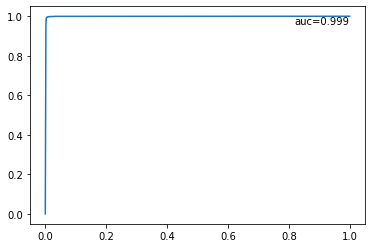

In [24]:
plt.plot(fpr, tpr)
plt.text(1, 1, f'auc={round(auc, 3)}', ha='right', va='top')